# Esperanza Old Development Notebook

### Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

import prophet as Prophet

Importing plotly failed. Interactive plots will not work.


In [10]:
floor_2 = pd.read_csv('merged_all_2F.csv', index_col = 'Unnamed: 0')
floor_3 = pd.read_csv('merged_all_3F.csv', index_col = 'Unnamed: 0')
floor_4 = pd.read_csv('merged_all_4F.csv', index_col = 'Unnamed: 0')

In [11]:
floor_2 = floor_2.drop(['Unnamed: 0.1', 'Unnamed: 0.1.1'], axis = 1)

In [12]:
floor_2.head(5)

,time,Common Setpoint,Actual Sup Flow SP,Zone Temperature,Actual Supply Flow,energy,Outside Air Temp,Humidity,Zone Temperature Next,Actual Supply Flow Next,Outside Air Temp Next,Humidity Next,energy Next
0,2018-01-03T20:57:39+00:00,72.5,330.0,75.2,318.73,10.109642,68.44,56.0,75.2,317.06,68.50,56.0,10.113301
1,2018-01-03T21:04:13+00:00,72.5,330.0,75.2,317.06,10.113301,68.50,56.0,75.7,314.34,68.25,56.0,10.099466
2,2018-01-03T21:10:44+00:00,72.5,330.0,75.7,314.34,10.099466,68.25,56.0,75.7,313.91,68.31,56.0,10.241028
3,2018-01-03T21:17:16+00:00,72.5,330.0,75.7,313.91,10.241028,68.31,56.0,75.7,318.31,68.44,57.0,10.187620
4,2018-01-03T21:23:44+00:00,72.5,330.0,75.7,318.31,10.187620,68.44,57.0,75.7,316.65,68.81,57.0,10.194055


In [13]:
floor_3 = floor_3.drop(['Unnamed: 0.1'], axis = 1)

In [14]:
floor_3.head(5)

,time,Common Setpoint,Actual Sup Flow SP,Zone Temperature,Actual Supply Flow,energy,Outside Air Temp,Humidity,Zone Temperature Next,Actual Supply Flow Next,Outside Air Temp Next,Humidity Next,energy Next
0,2018-07-05T00:58:48+00:00,72.0,295.0,73.75,287.56,9.067059,68.88,53.0,73.75,289.97,69.31,53.0,9.104582
1,2018-07-05T01:04:13+00:00,72.0,295.0,73.75,289.97,9.104582,69.31,53.0,73.75,291.17,68.88,53.0,9.377247
2,2018-07-05T01:09:37+00:00,72.0,295.0,73.75,291.17,9.377247,68.88,53.0,73.75,299.89,68.94,53.0,9.147068
3,2018-07-05T01:15:17+00:00,72.0,295.0,73.75,299.89,9.147068,68.94,53.0,73.75,294.97,69.13,53.0,9.198235
4,2018-07-05T01:20:55+00:00,72.0,295.0,73.75,294.97,9.198235,69.13,53.0,73.75,296.62,68.94,53.0,9.212810


In [15]:
floor_4 = floor_4.drop(['Unnamed: 0.1'], axis = 1)

In [16]:
floor_4.head(5)

,time,Common Setpoint,Actual Sup Flow SP,Zone Temperature,Actual Supply Flow,energy,Outside Air Temp,Humidity,Zone Temperature Next,Actual Supply Flow Next,Outside Air Temp Next,Humidity Next,energy Next
0,2018-09-23T22:59:39+00:00,72.0,722.73,75.25,733.46,23.554224,71.31,53.0,74.74,692.03,71.19,53.0,22.261861
1,2018-09-23T23:06:38+00:00,72.0,661.39,74.74,692.03,22.261861,71.19,53.0,74.74,654.06,71.19,53.0,19.471076
2,2018-09-23T23:13:38+00:00,72.0,624.95,74.74,654.06,19.471076,71.19,53.0,74.24,576.94,70.94,53.0,18.861571
3,2018-09-23T23:20:38+00:00,72.0,562.05,74.24,576.94,18.861571,70.94,53.0,74.24,558.88,70.94,53.0,17.087055
4,2018-09-23T23:27:37+00:00,72.0,532.93,74.24,558.88,17.087055,70.94,53.0,74.24,506.30,70.81,53.0,16.212959


In [17]:
floor_2['floor'] = 2
floor_3['floor'] = 3
floor_4['floor'] = 4

In [18]:
combined_floors = pd.concat([floor_2, floor_3, floor_4]).reset_index(drop = True)


In [11]:
combined_floors.head(5)

,Zone Num,time,Common Setpoint,Actual Sup Flow SP,Zone Temperature,Actual Supply Flow,energy,Outside Air Temp,Humidity,Zone Temperature Next,Actual Supply Flow Next,Outside Air Temp Next,Humidity Next,energy Next,floor
0,0,2018-01-03T20:57:39+00:00,72.5,330.0,75.2,318.73,10.109642,68.44,56.0,75.2,317.06,68.50,56.0,10.113301,2
1,1,2018-01-03T21:04:13+00:00,72.5,330.0,75.2,317.06,10.113301,68.50,56.0,75.7,314.34,68.25,56.0,10.099466,2
2,2,2018-01-03T21:10:44+00:00,72.5,330.0,75.7,314.34,10.099466,68.25,56.0,75.7,313.91,68.31,56.0,10.241028,2
3,3,2018-01-03T21:17:16+00:00,72.5,330.0,75.7,313.91,10.241028,68.31,56.0,75.7,318.31,68.44,57.0,10.187620,2
4,4,2018-01-03T21:23:44+00:00,72.5,330.0,75.7,318.31,10.187620,68.44,57.0,75.7,316.65,68.81,57.0,10.194055,2


In [20]:
combined_floors['time_transformed'] = combined_floors['time'].apply(lambda x: pd.Timestamp(x))

### Graph Analyses

<AxesSubplot:>

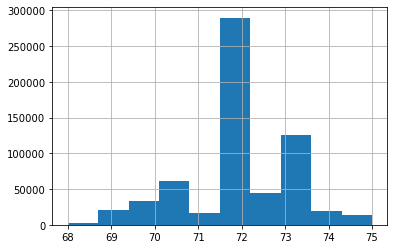

In [40]:
combined_floors['Common Setpoint'].hist()

<AxesSubplot:>

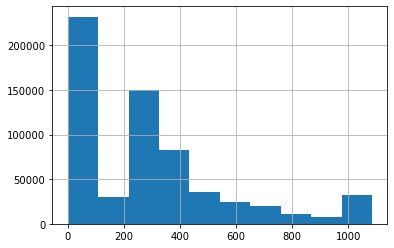

In [41]:
combined_floors['Actual Sup Flow SP'].hist()

<AxesSubplot:>

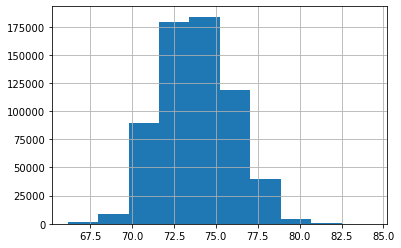

In [42]:
combined_floors['Zone Temperature'].hist()

<AxesSubplot:>

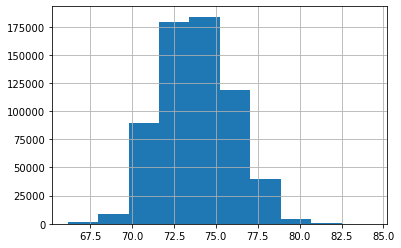

In [47]:
combined_floors['Zone Temperature Next'].hist()

<AxesSubplot:>

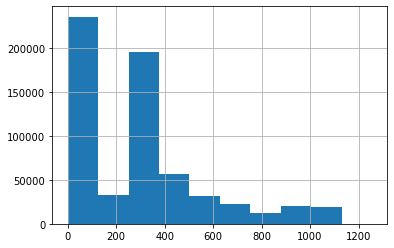

In [43]:
combined_floors['Actual Supply Flow'].hist()

<AxesSubplot:>

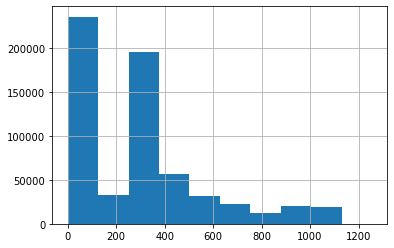

In [48]:
combined_floors['Actual Supply Flow Next'].hist()

<AxesSubplot:>

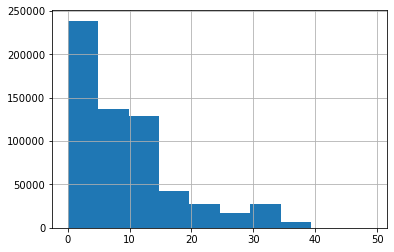

In [44]:
combined_floors['energy'].hist()

<AxesSubplot:>

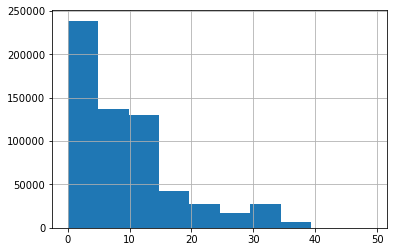

In [50]:
combined_floors['energy Next'].hist()

<AxesSubplot:>

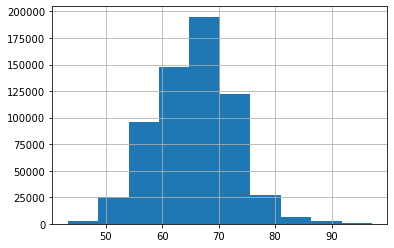

In [45]:
combined_floors['Outside Air Temp'].hist()

<AxesSubplot:>

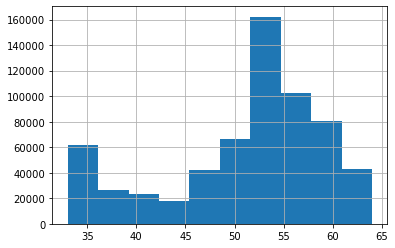

In [46]:
combined_floors['Humidity'].hist()

<AxesSubplot:>

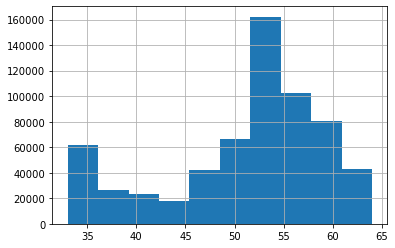

In [49]:
combined_floors['Humidity Next'].hist()

In [12]:
combined_floors.describe()

,Zone Num,Common Setpoint,Actual Sup Flow SP,Zone Temperature,Actual Supply Flow,energy,Outside Air Temp,Humidity,Zone Temperature Next,Actual Supply Flow Next,Outside Air Temp Next,Humidity Next,energy Next,floor
count,625677.000000,625677.000000,625677.000000,625677.000000,625677.000000,625677.000000,625677.000000,625677.000000,625677.000000,625677.000000,625677.000000,625677.000000,625677.000000,625677.000000
mean,222.267843,71.971029,281.969986,73.828747,286.652997,9.164442,65.607020,51.057912,73.828808,286.703274,65.607396,51.057221,9.166164,2.858858
std,134.384157,1.188391,285.399386,2.129463,278.804106,8.934812,6.870336,7.754473,2.129505,278.799565,6.870556,7.754866,8.935167,0.819037
min,0.000000,68.000000,0.000000,66.160000,0.000000,0.000000,43.280000,33.000000,66.160000,0.000000,43.280000,33.000000,0.000000,2.000000
25%,108.000000,72.000000,0.000000,72.290000,28.660000,0.908500,60.630000,48.000000,72.290000,28.660000,60.630000,48.000000,0.909160,2.000000
50%,218.000000,72.000000,295.000000,73.720000,295.240000,9.208460,65.810000,53.000000,73.720000,295.240000,65.810000,53.000000,9.209501,3.000000
75%,328.000000,73.000000,396.100000,75.340000,392.920000,12.390437,70.310000,57.000000,75.340000,393.030000,70.310000,57.000000,12.392090,4.000000
max,594.000000,75.000000,1085.000000,84.320000,1255.420000,49.165584,97.130000,64.000000,84.320000,1255.420000,97.130000,64.000000,49.165584,4.000000


In [52]:
combined_floors.shape

(625677, 15)

### Turning Time Values into different columns and evaluating

In [14]:
combined_floors['year'] = combined_floors['time_transformed'].transform(lambda x: x.year)

In [17]:
combined_floors['month'] = combined_floors['time_transformed'].transform(lambda x: x.month)

In [21]:
combined_floors['month'].value_counts()
# no values from March - May in any of the years ?

12    133394
11    105695
9      76136
7      70337
10     60515
1      55399
6      52013
8      47969
2      24219
Name: month, dtype: int64

In [19]:
combined_floors['day'] = combined_floors['time_transformed'].transform(lambda x: x.day)

In [ ]:
# data is supposed to be from July 2017 to the end of June 2018, but we have a little January 2019 and are missing months

### Splitting Dates for a 70/30 train/test split

In [22]:
dates = combined_floors['time_transformed'].transform(lambda x: x.date)

In [35]:
dates_2019 = (dates >= pd.Timestamp('2019-01-01'))

In [37]:
onwards_2019 = combined_floors.loc[dates_2019, :]

In [41]:
pre_2019 = combined_floors.loc[~dates_2019, :]

In [43]:
onwards_2019.shape

(8621, 16)

In [44]:
pre_2019.shape

(617056, 16)

This spans July 2017 to beginning of January 2019.

This is not enough data to segment via the year. if we want to go for a 70/30 split:

If we have a year and a half of data about, 50% of that would be 3/4 of a year. 75% of that would be 1 1/8 of a year, so about a year's worth of data would be about a year (estimating).



In [23]:
dates_test = (dates >= pd.Timestamp('2018-08-01'))

In [24]:
onwards_test_date = combined_floors.loc[dates_test, :]
pre_test_date = combined_floors.loc[~dates_test, :]


In [17]:
pre_test_date.shape

(437044, 16)

In [18]:
onwards_test_date.shape

(188633, 16)

In [19]:
188633 / (188633 + 437044)

0.3014862301155388

That's pretty close to a 70%, 30% split so I'll use that for the split. We could do the split at the 7th/8th of the month to try and match days better but I think this is fine.

### Trying out simple Linear and Decision Tree Models

In [25]:
import sklearn
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn import tree

In [22]:
pre_test_date_X = pre_test_date.loc[:, ['Zone Num', 'Common Setpoint', 'Actual Sup Flow SP', 'Zone Temperature', 'Actual Supply Flow', 'Outside Air Temp', 'Humidity', 'floor', 'time_transformed']]
pre_test_date_y = pre_test_date['energy']

onwards_test_date_X = onwards_test_date.loc[:, ['Zone Num', 'Common Setpoint', 'Actual Sup Flow SP', 'Zone Temperature', 'Actual Supply Flow', 'Outside Air Temp', 'Humidity', 'floor', 'time_transformed']]
onwards_test_date_y = onwards_test_date['energy']

In [29]:
pre_test_date_X['month'] = pre_test_date_X['time_transformed'].transform(lambda x: x.month)
pre_test_date_X['year'] = pre_test_date_X['time_transformed'].transform(lambda x: x.year)
pre_test_date_X['day'] = pre_test_date_X['time_transformed'].transform(lambda x: x.day)
pre_test_date_X['weekday'] = pre_test_date_X['time_transformed'].transform(lambda x: x.weekday)
pre_test_date_X['hour'] = pre_test_date_X['time_transformed'].transform(lambda x: x.hour)
pre_test_date_X['minute'] = pre_test_date_X['time_transformed'].transform(lambda x: x.minute)
pre_test_date_X['second'] = pre_test_date_X['time_transformed'].transform(lambda x: x.second)

In [31]:
onwards_test_date_X['month'] = onwards_test_date_X['time_transformed'].transform(lambda x: x.month)
onwards_test_date_X['year'] = onwards_test_date_X['time_transformed'].transform(lambda x: x.year)
onwards_test_date_X['day'] = onwards_test_date_X['time_transformed'].transform(lambda x: x.day)
onwards_test_date_X['weekday'] = onwards_test_date_X['time_transformed'].transform(lambda x: x.weekday)
onwards_test_date_X['hour'] = onwards_test_date_X['time_transformed'].transform(lambda x: x.hour)
onwards_test_date_X['minute'] = onwards_test_date_X['time_transformed'].transform(lambda x: x.minute)
onwards_test_date_X['second'] = onwards_test_date_X['time_transformed'].transform(lambda x: x.second)

In [32]:
pre_test_date_X = pre_test_date_X.drop(['time_transformed'], axis = 1)
onwards_test_date_X = onwards_test_date_X.drop(['time_transformed'], axis = 1)


#### Linear

In [33]:
regr = linear_model.LinearRegression()
regr.fit(pre_test_date_X, pre_test_date_y)

LinearRegression()

In [34]:
pre_y_pred = regr.predict(pre_test_date_X)


In [35]:
print("Mean squared error: %.2f" % mean_squared_error(pre_test_date_y, pre_y_pred))

Mean squared error: 2.70


In [51]:
onw_y_pred = regr.predict(onwards_test_date_X)

In [52]:
print("Mean squared error: %.2f" % mean_squared_error(onwards_test_date_y, onw_y_pred))

Mean squared error: 5.34


This doesn't really involve prediction though, mostly relies on having all of the data and evaluating. Our goal is to predict ahead.

#### Decision Tree

In [59]:
decTree = tree.DecisionTreeRegressor(max_depth = 5, min_samples_split = 5)
decTree.fit(pre_test_date_X, pre_test_date_y)

DecisionTreeRegressor(max_depth=5, min_samples_split=5)

In [60]:
preds_y_decTree = decTree.predict(pre_test_date_X)

In [61]:
print("Mean squared error: %.2f" % mean_squared_error(pre_test_date_y, preds_y_decTree))

Mean squared error: 2.58


In [62]:
preds_y_decTree_onw = decTree.predict(onwards_test_date_X)

In [63]:
print("Mean squared error: %.2f" % mean_squared_error(onwards_test_date_y, preds_y_decTree_onw))

Mean squared error: 4.64


Changed max_depth and min_samples_split values based on initial overtraining. Again doesn't fix the issue that we're not really able to predict ahead of time.

Some potential options to look into for sklearn:
- https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#sphx-glr-auto-examples-applications-plot-cyclical-feature-engineering-py
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

### Prophet Model

#### Need to rename columns and remove timezones to run Prophet

In [34]:
prophet_test_pre = pre_test_date.loc[:, ['time', 'energy']].rename({'time': 'ds', 'energy': 'y'}, axis = 1)

In [44]:
prophet_test_pre['ds'] = prophet_test_pre['ds'].transform(lambda x: x[0:-6])

Running the model.

In [36]:
prophet_model = Prophet.Prophet()

In [45]:
prophet_model.fit(prophet_test_pre)

14:34:43 - cmdstanpy - INFO - Chain [1] start processing
14:36:42 - cmdstanpy - INFO - Chain [1] done processing


In [66]:
prophet_forecast = prophet_model.make_future_dataframe(periods=365, freq='H')
prophet_forecast = prophet_model.predict(prophet_forecast)


In [68]:
prophet_forecast_reduced = prophet_forecast.loc[:, ['ds', 'yhat']]

In [69]:
prophet_forecast_reduced['timestamp_changed'] = prophet_forecast_reduced['ds'].transform(lambda x: pd.Timestamp(x))

In [60]:
onwards_compare = onwards_test_date.loc[:, ['time', 'energy']]
onwards_compare['time'] = onwards_compare['time'].transform(lambda x: x[0:-6])
onwards_compare = onwards_compare.rename({'time': 'ds', 'energy': 'yhat'}, axis = 1)
onwards_compare['timestamp_changed'] = onwards_compare['ds'].transform(lambda x: pd.Timestamp(x))

In [70]:
merge_test = prophet_forecast_reduced.merge(onwards_compare, left_on = 'timestamp_changed', right_on = 'timestamp_changed')

In [71]:
merge_test

,ds_x,yhat_x,timestamp_changed,ds_y,yhat_y


There should be values for this merge - because there isn't, we have to evaluate how we work with timestamps.

## Bonus - Exploring NOAA Data

In [24]:
noaa_data = pd.read_csv('NOAA_data_LaJollaSD.csv')

In [25]:
noaa_data.head(5)

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,DAPR,DAPR_ATTRIBUTES,MDPR,MDPR_ATTRIBUTES,PRCP,PRCP_ATTRIBUTES,SNOW,SNOW_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES
0,US1CASD0015,"LA JOLLA 2.5SE, CA US",32.825404,-117.239698,154.8,2017-01-01,NaN,NaN,NaN,NaN,0.68,",,N",NaN,NaN,NaN,NaN,NaN,NaN
1,US1CASD0015,"LA JOLLA 2.5SE, CA US",32.825404,-117.239698,154.8,2017-01-02,NaN,NaN,NaN,NaN,0.00,",,N",0.0,",,N",NaN,NaN,NaN,NaN
2,US1CASD0015,"LA JOLLA 2.5SE, CA US",32.825404,-117.239698,154.8,2017-01-03,NaN,NaN,NaN,NaN,0.00,",,N",0.0,",,N",NaN,NaN,NaN,NaN
3,US1CASD0015,"LA JOLLA 2.5SE, CA US",32.825404,-117.239698,154.8,2017-01-04,NaN,NaN,NaN,NaN,0.00,",,N",0.0,",,N",NaN,NaN,NaN,NaN
4,US1CASD0015,"LA JOLLA 2.5SE, CA US",32.825404,-117.239698,154.8,2017-01-05,NaN,NaN,NaN,NaN,0.00,",,N",0.0,",,N",NaN,NaN,NaN,NaN


In [26]:
noaa_data['DATE_TRANSFORMED'] =  noaa_data['DATE'].apply(lambda x: pd.Timestamp(x).date())

In [30]:
noaa_data.isna().sum() / len(noaa_data)

STATION             0.000000
NAME                0.000000
LATITUDE            0.000000
LONGITUDE           0.000000
ELEVATION           0.000000
DATE                0.000000
DAPR                0.998624
DAPR_ATTRIBUTES     0.998624
MDPR                0.998624
MDPR_ATTRIBUTES     0.998624
PRCP                0.001573
PRCP_ATTRIBUTES     0.001573
SNOW                0.559072
SNOW_ATTRIBUTES     0.559072
TMAX                0.647926
TMAX_ATTRIBUTES     0.647926
TMIN                0.648123
TMIN_ATTRIBUTES     0.648123
DATE_TRANSFORMED    0.000000
dtype: float64

In [32]:
noaa_data['NAME'].unique()

array(['LA JOLLA 2.5SE, CA US', 'LA JOLLA 2.1 SE, CA US',
       'SAN DIEGO SEAWORLD, CA US'], dtype=object)

We made a data request for La Jolla & for San Diego data - La Jolla gets us precipitation, but San Diego Seaworld was one of the closest zipcodes I could find that has the temperature information.

In [33]:
# segment by station:
lajolla_2_5 = noaa_data.loc[noaa_data['NAME'] == 'LA JOLLA 2.5SE, CA US', :]
lajolla_2_1 = noaa_data.loc[noaa_data['NAME'] == 'LA JOLLA 2.1 SE, CA US', :]
sd_seaworld = noaa_data.loc[noaa_data['NAME'] == 'SAN DIEGO SEAWORLD, CA US', :]

In [36]:
lajolla_2_5.isna().sum() / len(lajolla_2_5)

STATION             0.000000
NAME                0.000000
LATITUDE            0.000000
LONGITUDE           0.000000
ELEVATION           0.000000
DATE                0.000000
DAPR                0.998654
DAPR_ATTRIBUTES     0.998654
MDPR                0.998654
MDPR_ATTRIBUTES     0.998654
PRCP                0.001346
PRCP_ATTRIBUTES     0.001346
SNOW                0.153432
SNOW_ATTRIBUTES     0.153432
TMAX                1.000000
TMAX_ATTRIBUTES     1.000000
TMIN                1.000000
TMIN_ATTRIBUTES     1.000000
DATE_TRANSFORMED    0.000000
dtype: float64

In [37]:
lajolla_2_1.isna().sum() / len(lajolla_2_1)

STATION             0.00000
NAME                0.00000
LATITUDE            0.00000
LONGITUDE           0.00000
ELEVATION           0.00000
DATE                0.00000
DAPR                0.99724
DAPR_ATTRIBUTES     0.99724
MDPR                0.99724
MDPR_ATTRIBUTES     0.99724
PRCP                0.00276
PRCP_ATTRIBUTES     0.00276
SNOW                0.25759
SNOW_ATTRIBUTES     0.25759
TMAX                1.00000
TMAX_ATTRIBUTES     1.00000
TMIN                1.00000
TMIN_ATTRIBUTES     1.00000
DATE_TRANSFORMED    0.00000
dtype: float64

In [38]:
# Finding which data is relevant to participation
lajolla_2_5 = lajolla_2_5.drop(['TMAX', 'TMAX_ATTRIBUTES', 'TMIN', 'TMIN_ATTRIBUTES'], axis =1)
lajolla_2_1 = lajolla_2_1.drop(['TMAX', 'TMAX_ATTRIBUTES', 'TMIN', 'TMIN_ATTRIBUTES'], axis =1)


In [39]:
sd_seaworld.isna().sum() / len(sd_seaworld)

STATION             0.000000
NAME                0.000000
LATITUDE            0.000000
LONGITUDE           0.000000
ELEVATION           0.000000
DATE                0.000000
DAPR                1.000000
DAPR_ATTRIBUTES     1.000000
MDPR                1.000000
MDPR_ATTRIBUTES     1.000000
PRCP                0.000461
PRCP_ATTRIBUTES     0.000461
SNOW                1.000000
SNOW_ATTRIBUTES     1.000000
TMAX                0.174654
TMAX_ATTRIBUTES     0.174654
TMIN                0.175115
TMIN_ATTRIBUTES     0.175115
DATE_TRANSFORMED    0.000000
dtype: float64

In [40]:
# Getting data relevant to temperature
sd_seaworld = sd_seaworld.drop(['DAPR', 'DAPR_ATTRIBUTES', 'MDPR', 'MDPR_ATTRIBUTES', 'SNOW', 'SNOW_ATTRIBUTES'], axis =1)


In [45]:
sd_seaworld.shape

(2170, 13)

In [46]:
sd_seaworld.head(5)

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,PRCP_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES,DATE_TRANSFORMED
2917,USC00047741,"SAN DIEGO SEAWORLD, CA US",32.76536,-117.2315,4.3,2017-01-01,0.0,",,7,1630",61.0,",,7",47.0,",,7",2017-01-01
2918,USC00047741,"SAN DIEGO SEAWORLD, CA US",32.76536,-117.2315,4.3,2017-01-02,0.0,",,7,1630",59.0,",,7",52.0,",,7",2017-01-02
2919,USC00047741,"SAN DIEGO SEAWORLD, CA US",32.76536,-117.2315,4.3,2017-01-03,0.0,",,7,1630",59.0,",,7",48.0,",,7",2017-01-03
2920,USC00047741,"SAN DIEGO SEAWORLD, CA US",32.76536,-117.2315,4.3,2017-01-04,0.0,",,7,1630",61.0,",,7",46.0,",,7",2017-01-04
2921,USC00047741,"SAN DIEGO SEAWORLD, CA US",32.76536,-117.2315,4.3,2017-01-05,0.1,",,7,1630",60.0,",,7",55.0,",,7",2017-01-05


TMAX & TMIN attributes are a little confusing here - are they the max for the day?

In [48]:
lajolla_2_5.head(5)

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,DAPR,DAPR_ATTRIBUTES,MDPR,MDPR_ATTRIBUTES,PRCP,PRCP_ATTRIBUTES,SNOW,SNOW_ATTRIBUTES,DATE_TRANSFORMED
0,US1CASD0015,"LA JOLLA 2.5SE, CA US",32.825404,-117.239698,154.8,2017-01-01,NaN,NaN,NaN,NaN,0.68,",,N",NaN,NaN,2017-01-01
1,US1CASD0015,"LA JOLLA 2.5SE, CA US",32.825404,-117.239698,154.8,2017-01-02,NaN,NaN,NaN,NaN,0.00,",,N",0.0,",,N",2017-01-02
2,US1CASD0015,"LA JOLLA 2.5SE, CA US",32.825404,-117.239698,154.8,2017-01-03,NaN,NaN,NaN,NaN,0.00,",,N",0.0,",,N",2017-01-03
3,US1CASD0015,"LA JOLLA 2.5SE, CA US",32.825404,-117.239698,154.8,2017-01-04,NaN,NaN,NaN,NaN,0.00,",,N",0.0,",,N",2017-01-04
4,US1CASD0015,"LA JOLLA 2.5SE, CA US",32.825404,-117.239698,154.8,2017-01-05,NaN,NaN,NaN,NaN,0.00,",,N",0.0,",,N",2017-01-05
